# Проект e-commerce: Анализ совершенных покупок в интернет-магазине

### 1. Подготовка к работе

In [8]:
# Подгружаем данные

import pandas as pd 
import requests 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns
from urllib.parse import urlencode 
from datetime import timedelta
import datetime as dt
from operator import attrgetter
from utils import download_data 

In [9]:
# Подготавливаем общие настройки для графиков

sns.set(
    rc={
        "figure.figsize": (12, 8), #размер графика - 12 дюймов в ширину, 8 в длину
        "axes.titlesize": 20, #размер заголовка 
        "axes.labelsize": 14, #размер подписей осей
        "xtick.labelsize": 13, #размер подписей чёрточек на x-оси
        "ytick.labelsize": 13, #размер подписей чёрточек на y-оси
    }
)

sns.set_style("whitegrid") #тема фона, белая со штриховкой

%matplotlib inline 
#масштабируемые диаграммы

#### 2. Загрузка данных

2.1. В таблице заказов  **olist_orders_dataset.csv** имеется следующая информация:
* order_id —  уникальный идентификатор заказа (номер чека)
* customer_id —  позаказный идентификатор пользователя
* order_status —  статус заказа
  * created —  создан
  * invoiced —  выставлен счёт
  * approved —  подтверждён
  * processing —  в процессе сборки заказа
  * shipped —  отгружен со склада
  * delivered —  доставлен пользователю
  * unavailable —  недоступен
  * canceled —  отменён
* order_purchase_timestamp —  время создания заказа
* order_approved_at —  время подтверждения оплаты заказа
* order_delivered_carrier_date —  время передачи заказа в логистическую службу
* order_delivered_customer_date —  время доставки заказа
* order_estimated_delivery_date —  обещанная дата доставки

In [10]:
# Получаем таблицу с заказами
orders_df = download_data(
    public_key="https://disk.yandex.ru/d/ZhGseD1Wxb77jQ",
    local_path="./db/olist_orders_dataset.csv",
    separ=",",
    parse_date=[
        "order_purchase_timestamp",
        "order_approved_at",
        "order_delivered_carrier_date",
        "order_delivered_customer_date",
        "order_estimated_delivery_date",
    ],
)

2.2. В таблице товарные позиции, входящие в заказы  **olist_order_items_dataset.csv** имеется следующая информация:
* order_id —  уникальный идентификатор заказа (номер чека)
* order_item_id —  идентификатор товара внутри одного заказа
* product_id —  ид товара (аналог штрихкода)
* seller_id — ид производителя товара
* shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
* price —  цена за единицу товара
* freight_value —  вес товара

In [11]:
# Получаем таблицу с товараными позициями, входящими в заказы
items_df = download_data(
    public_key="https://disk.yandex.ru/d/G2W6YkBrUDO87A",
    local_path="./db/olist_order_items_dataset.csv",
    separ=",",
    parse_date=["shipping_limit_date"],
)

2.3. В таблице с уникальными идентификаторами пользователей  **olist_customers_dataset.csv** имеется следующая информация:
* customer_id — позаказный идентификатор пользователя
* customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)
* customer_zip_code_prefix —  почтовый индекс пользователя
* customer_city —  город доставки пользователя
* customer_state —  штат доставки пользователя

In [12]:
clients_df = download_data(
    public_key="https://disk.yandex.ru/d/Pnf8VyFce0uWDA",
    local_path="./db/olist_customers_dataset.csv",
    separ=",",
)

#### 3. Проведем EDA
Рассмотрим базовую информацию по датафреймам: 
* Описатательную статистику
* Проверим на дубликаты
* Проверим на n/a


3.1. EDA таблица заказы

In [13]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [14]:
#  Проверка наличия дубликатов в столбце order_id
is_duplicate = orders_df["order_id"].duplicated().any()

if is_duplicate:
    print("Столбец содержит дубликаты")
else:
    print("Столбец не содержит дубликаты")

Столбец не содержит дубликаты


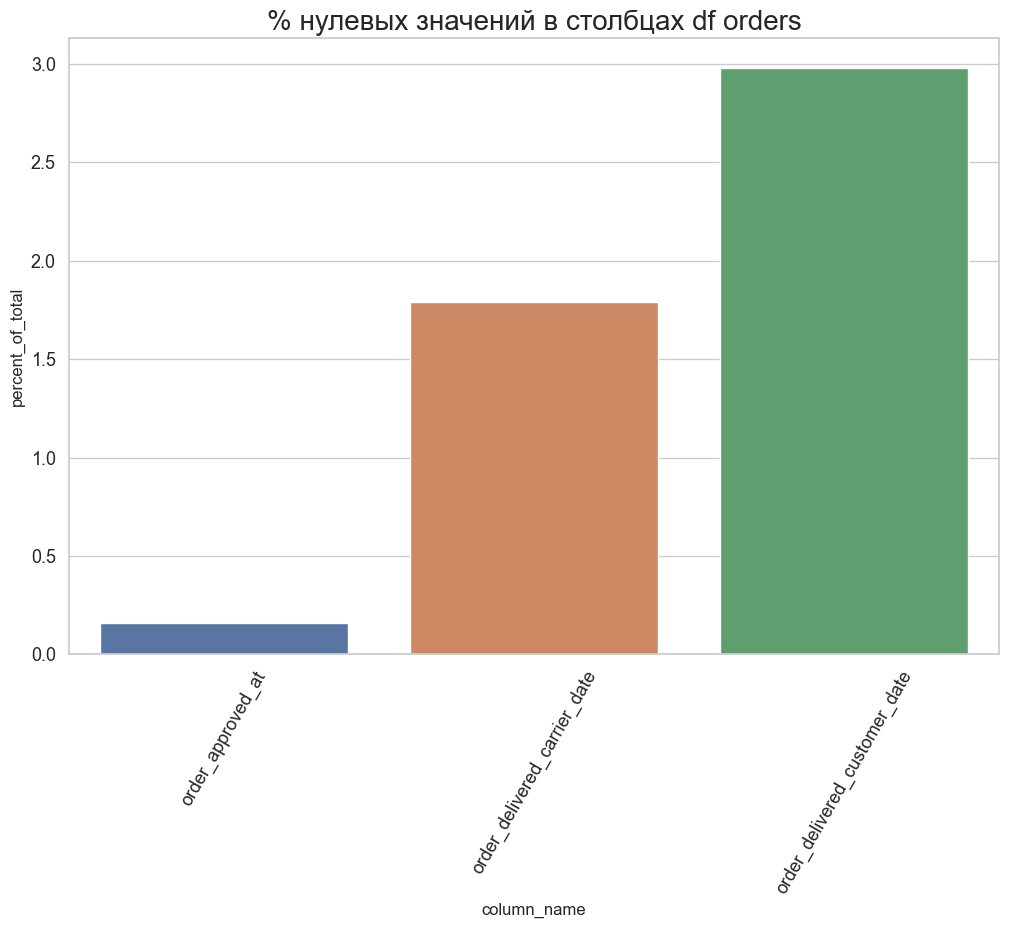

In [15]:
#  Подсчет нулевых значений в каждой колонке
null_values = orders_df.isnull().sum()
# Нормализация значений
# # Оставляем только колонки, где есть нулевые значения
null_values = null_values[null_values > 0]
# Преобразование Series в DataFrame для построения графика
null_values_df = (
    pd.DataFrame(null_values, columns=["count_nulls"])
    .rename_axis("column_name")
    .reset_index()
)
# Выводим общее количество строк
total_cells_orders = orders_df.shape[0]
# Считаем % нулевых значений ко всем
null_values_df["percent_of_total"] = (
    null_values_df.count_nulls / total_cells_orders
) * 100

# Создаем график с подсчетом нулевых значений по столбцам
sns.barplot(data=null_values_df, x="column_name", y="percent_of_total")
plt.xticks(rotation=60)  # Установка угла поворота в градусах
# Задание заголовка графика
plt.title("% нулевых значений в столбцах df orders")
plt.show()

In [16]:
# Посмотрим на заказы с точки зрения их фактических статусов в % соотношении
percent_of_status = (
    orders_df.order_status.value_counts(normalize=True).mul(100).round(2)
)
percent_of_status = pd.Series(percent_of_status, name="percent_of_status")
percent_of_status

delivered      97.02
shipped         1.11
canceled        0.63
unavailable     0.61
invoiced        0.32
processing      0.30
created         0.01
approved        0.00
Name: percent_of_status, dtype: float64

Рассмотрм подробнее заказы со статусом "delivered". Сколько времени занимает переход заказа от статуса к статусу

In [17]:
# отфильтруем df с заказами по статусу "доставлен"
delivered_df = orders_df.query('order_status=="delivered"')
# уберем пустые значения из колонок с датами
delivered_df = delivered_df[
    delivered_df["order_approved_at"].notna()
    & delivered_df["order_delivered_carrier_date"].notna()
    & delivered_df["order_delivered_customer_date"].notna()
]
# Посмотрим на описательную статистику времени перехода заказа от статуса к статусу.
# Кол-во времени для перехода от:
# Оплачен -> Подтвержден
delivered_df["purchased_approved"] = (
    delivered_df.order_approved_at - delivered_df.order_purchase_timestamp
)
# Подтвержден -> Доставлен в лог.службу
delivered_df["approved_deliveredcarrier"] = (
    delivered_df.order_delivered_carrier_date - delivered_df.order_approved_at
)
# Из лог.службы -> Доставлен клиенту
delivered_df["deliveredcarrier_deliveredcustomer"] = (
    delivered_df.order_delivered_customer_date
    - delivered_df.order_delivered_carrier_date
)
# Оставляем только нужные колонки и смотрим на описательную статистику
delivered_df[
    [
        "order_id",
        "order_status",
        "purchased_approved",
        "approved_deliveredcarrier",
        "deliveredcarrier_deliveredcustomer",
    ]
].describe(include="timedelta")

,purchased_approved,approved_deliveredcarrier,deliveredcarrier_deliveredcustomer
count,96455,96455,96455
mean,0 days 10:16:39.727904204,2 days 19:10:37.798424135,9 days 07:55:47.128391477
std,0 days 20:32:10.134771828,3 days 12:53:31.746860544,8 days 18:15:07.511611066
min,0 days 00:00:00,-172 days +18:44:38,-17 days +21:41:31
25%,0 days 00:12:55,0 days 20:58:51.500000,4 days 02:23:31.500000
50%,0 days 00:20:36,1 days 19:34:46,7 days 02:23:34
75%,0 days 14:31:02.500000,3 days 13:47:54,12 days 00:41:55.500000
max,30 days 21:26:37,125 days 18:18:06,205 days 04:35:00


**Вывод:** Присутствие отрицательных значений уже после отсечки пустых значений, свидетельствует об ошибках внесения данных в бд (логика событий нарушена. Например: подтверждение заказа происходит позднее, чем его доставка в логистическую службу или доставка клиенту наступает раньше, чем доставка в логистическую службу)

In [18]:
# Посчитаем количество доставленных заказов с ошибкой в данных
valid_orders = delivered_df[
    (delivered_df["approved_deliveredcarrier"] > pd.Timedelta(seconds=0))
    & (delivered_df["deliveredcarrier_deliveredcustomer"] > pd.Timedelta(seconds=0))
].shape[0]
all_orders = delivered_df.shape[0]
percent_of_errors = round(((all_orders - valid_orders) / all_orders * 100), 2)
f" Вывод: Количесвто доставленных заказов с ошибкой в данных {percent_of_errors} %"

' Вывод: Количесвто доставленных заказов с ошибкой в данных 1.43 %'

3.2. EDA таблица товароы

In [19]:
items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


In [20]:
items_df.describe()

,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000


In [21]:
# Количество уникальных товаров
uniq_items = items_df["product_id"].nunique()
# Количество уникальных заказов в таблице товаров
uniq_orders = items_df["order_id"].nunique()
f" количество заказов в таблице товаров = {uniq_orders}, а товаров = {uniq_items}"

' количество заказов в таблице товаров = 98666, а товаров = 32951'

3.3. EDA таблица клиентов

In [22]:
clients_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [23]:
clients_df.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [24]:
unique_id = clients_df["customer_unique_id"].nunique()
customer_id = clients_df["customer_id"].nunique()
f" Количество уникальных id = {unique_id}, количество id = {customer_id}"

' Количество уникальных id = 96096, количество id = 99441'

3.4. Проведем объединение таблиц **orders-items-customers**:
- в таблице заказов оставим только заказы со статусами (approved, invoiced, processing, shipped, delivered) и будем считать это покупкой
- из таблицы клиентов берем уникальный id (customer_unique_id) и присоединим к покупкам
- фильтруем таблицу товаров, оставляя только те заказы, которые считаем покупккой
- построим графики распределния для для количества товаров в заказах и стоимости заказов

In [25]:
# Оставляем в таблице заказов только те, которые считаем покупкой
true_orders_df = orders_df[
    (orders_df.order_status != "created")
    & (orders_df.order_status != "unavailable")
    & (orders_df.order_status != "canceled")
]
# Присоединяем к покупкам уникальный id клиента
columns_to_keep_orders = [
    "order_id",
    "order_status",
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
    "customer_unique_id",
]
true_orders_df = true_orders_df.merge(clients_df, how="left", on="customer_id")[
    columns_to_keep_orders
]
# Создаем переменные для вывода f строки
true_orders = true_orders_df["order_id"].nunique()
true_clients = true_orders_df["customer_unique_id"].nunique()

f"Вывод: имеем {true_orders} заказов и {true_clients} уникальных покупателей"

'Вывод: имеем 98202 заказов и 94986 уникальных покупателей'

In [26]:
# В таблице товаров оставим только те заказы, которые считаем покупкой
columns_to_keep_items = ["order_id", "product_id", "price", "order_purchase_timestamp"]
bought_items_df = items_df.merge(true_orders_df, how="right", on="order_id")[
    columns_to_keep_items
]
# Посчитам стоимость заказов
bought_items_df["order_price"] = bought_items_df.groupby("order_id")["price"].transform(
    "sum"
)
bought_items_df["items_in_order"] = bought_items_df.groupby("order_id")[
    "product_id"
].transform("count")
# Посчитаем количество позиций в заказе
# Создаем переменные для вывода f строки
true_orders_items = bought_items_df["order_id"].nunique()
true_items = bought_items_df["product_id"].nunique()
f"Вывод: имеем {true_orders_items} заказов и {true_items} уникальных товаров"

'Вывод: имеем 98202 заказов и 32729 уникальных товаров'

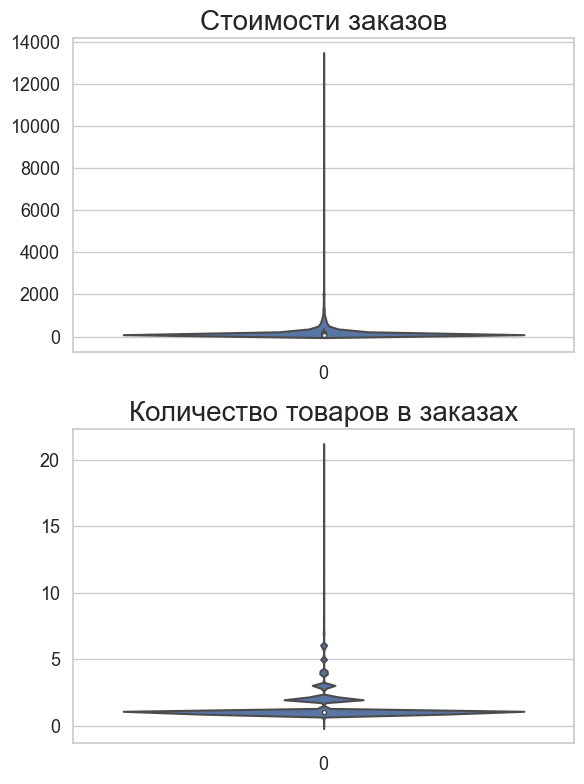

In [27]:
# Построим violinchart, чтобы посмотреть на распределения количества товаров в заказах и Стоимости заказов
# Создание фигуры и осей
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 8), sharey=False)

# Построение violinplot
sns.violinplot(bought_items_df["order_price"], ax=axes[0])
axes[0].set_title("Стоимости заказов")

sns.violinplot(data=bought_items_df["items_in_order"], ax=axes[1])
axes[1].set_title("Количество товаров в заказах")

# Отображение графиков
plt.tight_layout()
plt.show()

## 4. AD-HOC анализ
Получаем ответы на вопросы:
* Сколько у нас пользователей, которые совершили покупку только один раз?
* Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 
* По каждому товару определить, в какой день недели товар чаще всего покупается?
* Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

 **Вопрос 1.** Сколько у нас пользователей, которые совершили покупку только один раз?

In [28]:
# Формируем df по пользователю с подсчетом количества совершенных покупок
orders_by_customer_df = true_orders_df.groupby(
    "customer_unique_id", as_index=False
).agg(orders=("order_id", "nunique"))
# Фильтруем df по пользователям у  которых только одна покупка
customers_w_one_purchase = orders_by_customer_df.loc[
    orders_by_customer_df.orders == 1
].shape[0]
f"Ответ: {customers_w_one_purchase} пользователей совершили покупку только один раз"

'Ответ: 92099 пользователей совершили покупку только один раз'

**Вопрос 2.** Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам) ?

In [29]:
# Создаем df недоставленных заказов
not_delivered_orders = orders_df.query('order_status != "delivered"').copy()
# Переводим order_purchase_timestamp в формат год-месяц
not_delivered_orders["order_purchase_timestamp"] = pd.to_datetime(
    not_delivered_orders["order_purchase_timestamp"]
)
not_delivered_orders["order_purchase_yearmonth"] = not_delivered_orders[
    "order_purchase_timestamp"
].dt.strftime("%Y-%m")
# Сделаем df с подсчетом недоставленных заказов по году-месяцу и статусу
not_delivered_orders_details = not_delivered_orders.groupby(
    ["order_purchase_yearmonth", "order_status"], as_index=False
).agg(quantity=("order_id", "count"))
# Посчитаем среднее значение недоставленных заказов по году-месяцу
not_delivered_orders_details["undelivered_mean"] = not_delivered_orders_details.groupby(
    "order_purchase_yearmonth"
)["quantity"].transform("mean")
not_delivered_orders_details.head().style.set_caption(
    "2. В среднем (undelivered_mean) не доставляется заказов в месяц"
)

,order_purchase_yearmonth,order_status,quantity,undelivered_mean
0,2016-09,canceled,2,1.500000
1,2016-09,shipped,1,1.500000
2,2016-10,canceled,24,11.800000
3,2016-10,invoiced,18,11.800000
4,2016-10,processing,2,11.800000


**Вопрос 3.** По каждому товару определить, в какой день недели товар чаще всего покупается?

In [30]:
# Выставляем день недели
bought_items_df["day_name"] = bought_items_df.order_purchase_timestamp.dt.day_name()
# Агрегируем данные по продукту и названию дня недели. С помощью "моды" ищем самые частые дни.
# Для некоторых товаров имеем несколько best days, потому что их покупали одинаковое количество раз в эти дни, т.е. имеют две моды.
days = (
    bought_items_df[["product_id", "day_name"]]
    .groupby("product_id", as_index=False)
    .agg({"day_name": pd.Series.mode})
)
days.head(5).style.set_caption("3. Дни недели, в которые товар чаще всего покупается")

,product_id,day_name
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Thursday
3,000b8f95fcb9e0096488278317764d19,['Friday' 'Wednesday']
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday


**Вопрос 4.** Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели.

In [31]:
# pd.options.mode.chained_assignment = None  # default='warn'
# Обрезаем df оставляя только нужные поля
orders_by_customer = true_orders_df[
    ["order_id", "order_purchase_timestamp", "customer_unique_id"]
].copy()
# Считаем количество недель в каждом месяце
orders_by_customer["weeks_in_month"] = np.round(
    ((orders_by_customer.order_purchase_timestamp.dt.daysinmonth) / 7), 2
)
# Приводим дату к формату первое число месяца
orders_by_customer["01_month_year"] = (
    orders_by_customer["order_purchase_timestamp"].apply(lambda x: x.replace(day=1))
).dt.date
boughts_by_week = orders_by_customer.groupby(
    ["customer_unique_id", "01_month_year", "weeks_in_month"], as_index=False
).agg(orders=("order_id", "nunique"))
# Находим среднее кол-во покупок в неделю в разрезе месяцев
boughts_by_week["means"] = boughts_by_week.orders / boughts_by_week.weeks_in_month
boughts_by_week = boughts_by_week[
    ["customer_unique_id", "01_month_year", "means"]
].sort_values("01_month_year")
boughts_by_week.head(5).style.set_caption(
    "4: Среднее кол-во покупок в неделю у клиентов по месяцам"
)

,customer_unique_id,01_month_year,means
49701,830d5b7aaa3b6f1e9ad63703bec97d23,2016-09-01,0.233100
69648,b7d76e111c89f7ebf14761390f0f7d17,2016-09-01,0.233100
81656,d78014098f313770fc276a44a9e84a87,2016-10-01,0.225734
3124,0829f7df6577d5a4b65439bea701405f,2016-10-01,0.225734
62784,a5afc2fc6cbdb37998250ef5c42eab15,2016-10-01,0.225734


## 5. Когортный анализ пользователей. 
В период с января по декабрь выявить когорту с самым высоким retention на 3й месяц. 

*Данные представлены за несколько лет, проверим все ли года полные (имеется информация за все месяцы года) т.к. по заданию нас интересует период с января по декабрь.*

In [32]:
true_orders_df["date_purch"] = pd.to_datetime(
    true_orders_df["order_purchase_timestamp"]
).dt.strftime("%Y-%m")
true_orders_df["year"] = true_orders_df["order_purchase_timestamp"].dt.year
full_years_df = true_orders_df.groupby("year").agg(
    months_w_data=("date_purch", "nunique")
)
vivod = f"Вывод: Данные за весь год есть только в 2017. Поэтому отфильтруем df по нему"
print(full_years_df, vivod)

      months_w_data
year               
2016              3
2017             12
2018              9 Вывод: Данные за весь год есть только в 2017. Поэтому отфильтруем df по нему


In [33]:
# Готовим df к когортному анализу (оставляем только нужные столбцы)
df_to_cohort = true_orders_df.query("year==2017").copy()
# Преобразуем дату заказа в формат год-месяц-день
df_to_cohort["date"] = pd.to_datetime(
    df_to_cohort["order_purchase_timestamp"].dt.strftime("%Y-%m-%d")
)
df_to_cohort["order_month"] = pd.to_datetime(
    df_to_cohort["order_purchase_timestamp"]
).dt.to_period("M")
df_to_cohort["cohort"] = (
    df_to_cohort.groupby("customer_unique_id")["date"].transform("min")
).dt.to_period("M")
df_to_cohort = df_to_cohort[["order_id", "order_month", "customer_unique_id", "cohort"]]
df_to_cohort = (
    df_to_cohort.groupby(["cohort", "order_month"])
    .agg(n_customers=("customer_unique_id", "nunique"))
    .reset_index(drop=False)
)
df_to_cohort["period_number"] = (df_to_cohort.order_month - df_to_cohort.cohort).apply(
    attrgetter("n")
)
cohort_pivot = df_to_cohort.pivot_table(
    index="cohort", columns="period_number", values="n_customers"
)
cohort_size = cohort_pivot.iloc[:, 0]
retention = cohort_pivot.divide(cohort_size, axis=0).round(3)

ur_style = (
    retention.style.set_caption(
        "Задача 5: Когортный анализ пользователей"
    )  # добавляем подпись
    .background_gradient(cmap="Reds")  # раскрашиваем ячейки по столбцам
    .highlight_null("white")  # делаем белый фон для значений NaN
    .format("{:.2%}", na_rep="")
)  # числа форматируем как проценты, NaN заменяем на пустоту
ur_style

period_number,0,1,2,3,4,5,6,7,8,9,10,11
cohort,,,,,,,,,,,,
2017-01,100.00%,0.40%,0.30%,0.10%,0.40%,0.10%,0.40%,0.10%,0.10%,,0.40%,0.10%
2017-02,100.00%,0.20%,0.30%,0.10%,0.40%,0.10%,0.20%,0.20%,0.10%,0.20%,0.10%,
2017-03,100.00%,0.50%,0.40%,0.40%,0.40%,0.20%,0.20%,0.30%,0.40%,0.10%,,
2017-04,100.00%,0.60%,0.20%,0.20%,0.30%,0.30%,0.30%,0.30%,0.30%,,,
2017-05,100.00%,0.50%,0.50%,0.40%,0.30%,0.30%,0.40%,0.10%,,,,
2017-06,100.00%,0.50%,0.40%,0.40%,0.30%,0.40%,0.40%,,,,,
2017-07,100.00%,0.50%,0.30%,0.20%,0.30%,0.20%,,,,,,
2017-08,100.00%,0.70%,0.30%,0.30%,0.40%,,,,,,,
2017-09,100.00%,0.70%,0.50%,0.30%,,,,,,,,


In [34]:
# Находим когорту с самым высоким retention на 3й месяц
maximum = retention[2].max()
period_w_max = retention.loc[retention[2] == maximum][2].index[0:]
coh_max = retention.loc[retention[2] == maximum][2].max()
f"Вывод: Самый высокий retention за третий месяц в когортах:{period_w_max} и равен {coh_max}"

"Вывод: Самый высокий retention за третий месяц в когортах:PeriodIndex(['2017-05', '2017-09'], dtype='period[M]', name='cohort') и равен 0.005"

## 6. RFM-сегментация пользователей 
* R - время от последней покупки пользователя до текущей даты, 
* F - суммарное количество покупок у пользователя за всё время, 
* M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. 

*Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.* 

In [35]:
# Создаем df для RFM анализа

price_for_rfm_df = bought_items_df[["order_price", "order_id"]].drop_duplicates(
    subset="order_id"
)

df_4_rfm = true_orders_df[
    ["order_id", "order_purchase_timestamp", "customer_unique_id"]
].merge(price_for_rfm_df[["order_price", "order_id"]], how="left", on="order_id")
# Создаем колонку последней даты, относительно нее будем считать Recency
now = df_4_rfm.order_purchase_timestamp.max() + timedelta(days=1)
# Для каждого заказа считаем кол-во прошедших дней
df_4_rfm["days_since_order"] = df_4_rfm["order_purchase_timestamp"].apply(
    lambda x: (now - x).days
)
# Группируем df по клиенту и рассяитываем r-f-m
rfm_df = df_4_rfm.groupby("customer_unique_id", as_index=False).agg(
    recency=("days_since_order", "min"),
    frequency=("order_id", "nunique"),
    monetary=("order_price", "sum"),
)

In [36]:
# Рассчитываем квантили, так чтобы получилось 5 категорий
quintiles = (
    rfm_df[["recency", "frequency", "monetary"]]
    .quantile([0.2, 0.4, 0.6, 0.8])
    .to_dict()
)
quintiles

{'recency': {0.2: 98.0, 0.4: 182.0, 0.6: 273.0, 0.8: 388.0},
 'frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 109.9, 0.8: 179.9}}

In [37]:
# Функции присвоения рангов от 1 до 5. Меньшее значение recency лучше, чем более высокие frequency и monetary тем лучше.
def r_score(x):
    if x <= quintiles["recency"][0.2]:
        return 5
    elif x <= quintiles["recency"][0.4]:
        return 4
    elif x <= quintiles["recency"][0.6]:
        return 3
    elif x <= quintiles["recency"][0.8]:
        return 2
    else:
        return 1


def fm_score(x, c):
    if x <= quintiles[c][0.2]:
        return 1
    elif x <= quintiles[c][0.4]:
        return 2
    elif x <= quintiles[c][0.6]:
        return 3
    elif x <= quintiles[c][0.8]:
        return 4
    else:
        return 5

In [38]:
# Расставляем рейтини
rfm_df["R"] = rfm_df["recency"].apply(lambda x: r_score(x))
rfm_df["F"] = rfm_df["frequency"].apply(lambda x: fm_score(x, "frequency"))
rfm_df["M"] = rfm_df["monetary"].apply(lambda x: fm_score(x, "monetary"))
# Считаем итоговый score
rfm_df["rfm_score"] = rfm_df["R"].map(str) + rfm_df["F"].map(str) + rfm_df["M"].map(str)

In [39]:
# Результаты RFM-оценок дают нам 125 сегментов. Будем работать с 11 сегментами на основе оценок R и F. Названия сегментов взято
# из https://guillaume-martin.github.io/rfm-segmentation-with-python.html

segt_map = {
    r"[1-2][1-2]": "hibernating",
    r"[1-2][3-4]": "at risk",
    r"[1-2]5": "can't loose",
    r"3[1-2]": "about to sleep",
    r"33": "need attention",
    r"[3-4][4-5]": "loyal customers",
    r"41": "promising",
    r"51": "new customers",
    r"[4-5][2-3]": "potential loyalists",
    r"5[4-5]": "champions",
}

rfm_df["Segment"] = rfm_df["R"].map(str) + rfm_df["F"].map(str)
rfm_df["Segment"] = rfm_df["Segment"].replace(segt_map, regex=True)

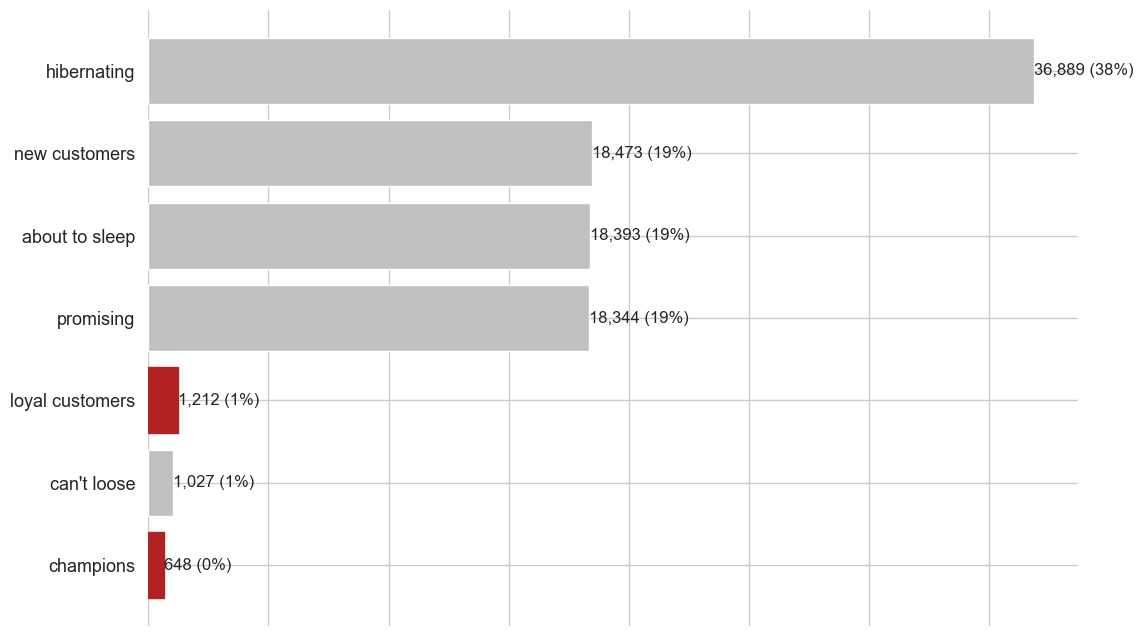

In [40]:
# Визуализируем количество клиентов по сегментам
segments_counts = rfm_df["Segment"].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)), segments_counts, color="silver")
ax.set_frame_on(False)
ax.tick_params(left=False, bottom=False, labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
    value = bar.get_width()
    if segments_counts.index[i] in ["champions", "loyal customers"]:
        bar.set_color("firebrick")
    ax.text(
        value,
        bar.get_y() + bar.get_height() / 2,
        "{:,} ({:}%)".format(int(value), int(value * 100 / segments_counts.sum())),
        va="center",
        ha="left",
    )

plt.show()

### Легенда
**Чемпионы (champions)** - Недавно приобретенные клиенты, часто делающие покупки и тратящие больше всего денег.

**Лояльные клиенты (loyal customers)** Регулярно делают покупки. Реагируют на акции и специальные предложения.

**Потенциальные лоялисты (potential loyalists)** Недавние клиенты со средней частотой покупок.

**Недавние клиенты (Recent Customers)** Совершили последнюю покупку недавно, но покупают не часто.

**Многообещающие Недавние покупатели (Promising Recent shoppers)**, но не тратят много.

**Клиенты, требующие внимания: Выше среднего значения по показателям недавности, частоты покупок и денежной стоимости (Customers Needing Attention)** Могли недавно не делать покупок.

**Скоро потеряем (About To Sleep)** Показатели недавности и частоты покупок ниже среднего значения.

**На грани потери (At Risk)** Делали покупки часто, но давно. Необходимо вернуть их обратно!

**Не можем потерять (Can’t Lose Them)** Раньше часто покупали, но давно не возвращаются.

**Спящие (Hibernating)** Последняя покупка была совершена давно, и количество заказов невелико. Могут считаться потеряными.

### Вывод:
Большая часть клиентов находятся на грани потери: (39%) - "спящие", 19% - "скоро потеряем" и почти 40% - это новые клиенты и потенциалльно лояльные к продукту.